## Testing Different type of Decision Tree models on the Data

In [47]:

import warnings
warnings.filterwarnings('ignore')


In [48]:
%matplotlib inline

import os, sys
from pathlib import Path

import numpy as np
from scipy.stats import spearmanr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

import statsmodels.api as sm

In [49]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [50]:


sns.set_style('white')

results_path = Path('results', 'decision_trees')
if not results_path.exists():
    results_path.mkdir(parents=True)

##### Importing the data prepared in data_prep.ipynb

In [51]:


with pd.HDFStore('data.h5') as store:
    data = store['CRYPTO/DAILY']
data.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 996 entries, 2019-05-25 to 2022-03-09
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   close    996 non-null    float64
 1   open     996 non-null    float64
 2   high     996 non-null    float64
 3   low      996 non-null    float64
 4   rsi      996 non-null    float64
 5   bb_high  996 non-null    float64
 6   bb_mid   996 non-null    float64
 7   bb_low   996 non-null    float64
 8   bb_up    996 non-null    float64
 9   bb_down  996 non-null    float64
 10  atr      996 non-null    float64
 11  natr     996 non-null    float64
 12  macd     996 non-null    float64
 13  ULTOSC   996 non-null    float64
 14  Target   996 non-null    float64
dtypes: float64(15)
memory usage: 124.5 KB


In [97]:
X = data.loc[:,['close','close','Target']]
X.columns = ['x0', 'x1','y1']
X['x0'] = X['y1'].shift()
X['x1'] = X['x0'].shift()
X = X.dropna()
Y = X['y1']
X = X.drop('y1', axis=1)
X

,x0,x1
date,,
2019-05-27,0.013373,0.081190
2019-05-28,-0.015713,0.013373
2019-05-29,-0.006235,-0.015713
2019-05-30,-0.028892,-0.006235
2019-05-31,0.025221,-0.028892
...,...,...
2022-03-03,-0.019651,-0.023378
2022-03-06,-0.105960,-0.019651
2022-03-07,0.014129,-0.105960


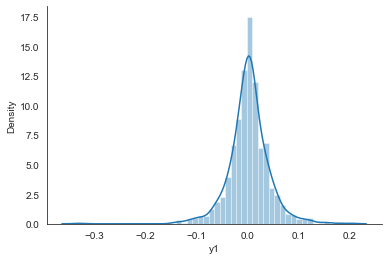

In [84]:
sns.distplot(Y)
sns.despine()

### Decision Tree Regressor

In [85]:
reg_tree_t2 = DecisionTreeRegressor(criterion='mse',
                                    splitter='best',
                                    max_depth=6,
                                    min_samples_split=2,
                                    min_samples_leaf=50,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None)

In [86]:
%%timeit
reg_tree_t2.fit(X=X, y=Y)

2.21 ms ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
reg_tree_t2.fit(X=X, y=Y)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=50, random_state=42)

Visualising the model using graphviz Library

In [ ]:
out_file = results_path / 'reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file.as_posix(),
                          feature_names=X.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

Comparison with Linear Regression

In [89]:


ols_model = sm.OLS(endog=Y, exog=sm.add_constant(X))



In [90]:
%%timeit
ols_model.fit()

7.31 µs ± 85.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [91]:
result = ols_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.877
Date:                Fri, 11 Mar 2022   Prob (F-statistic):              0.154
Time:                        20:37:53   Log-Likelihood:                 1796.3
No. Observations:                 994   AIC:                            -3587.
Df Residuals:                     991   BIC:                            -3572.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.959      0.0

sklearn Linear Regression

In [92]:


lin_reg = LinearRegression()



In [93]:
%%timeit
lin_reg.fit(X=X,y=Y)

1.43 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [94]:
lin_reg.fit(X=X,y=Y)

LinearRegression()

In [95]:
lin_reg.intercept_

0.0024801672251796333

In [24]:
lin_reg.coef_


array([-6.04805456e-06,  7.92948504e-07,  2.44541816e-06,  2.05142006e-06,
        6.50111877e-05,  1.25826736e-02,  6.53977563e-03,  4.96877660e-04,
        3.47602462e-02, -2.26744503e-02, -4.23185841e-03,  8.30669724e-04,
        2.64252313e-03,  5.23454071e-04])

In [101]:
x0, x1 = np.meshgrid(np.linspace(X['x0'].quantile(.01), X['x0'].quantile(.99), 100),
                     np.linspace(X['x1'].quantile(.01), X['x1'].quantile(.99), 100))
X_data = np.c_[x0.ravel(), x1.ravel()]

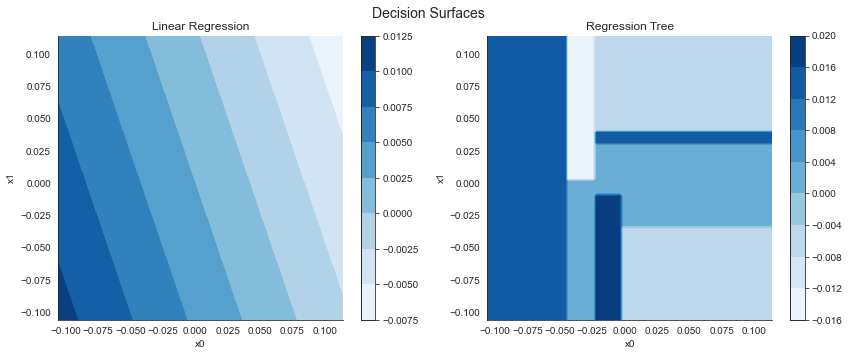

In [102]:


fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
rex0 = lin_reg.predict(X_data).reshape(x0.shape)
surface1 = axes[0].contourf(x0,x1, rex0, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = reg_tree_t2.predict(X_data).reshape(x0.shape)
surface2 = axes[1].contourf(x0,x1, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)



In [104]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=5,
                                     min_samples_split=1000,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     class_weight=None)

In [105]:
y_binary = (Y>0).astype(int)
y_binary.value_counts()

1    540
0    454
Name: y1, dtype: int64

In [106]:
%%timeit
clf_tree_t2.fit(X=X, y=y_binary)

2.18 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [107]:
clf_tree_t2.fit(X=X, y=y_binary)

DecisionTreeClassifier(max_depth=5, min_samples_split=1000, random_state=42)

In [ ]:
out_file = results_path / 'clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file.as_posix(),
                           feature_names=X.columns,
                           class_names=['Down', 'Up'],
                           max_depth=2,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [111]:


log_reg_sm = sm.Logit(endog=y_binary, exog=sm.add_constant(X))



In [112]:


%%timeit
log_reg_sm.fit(disp=False)



1.6 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [113]:
log_result = log_reg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.687126
         Iterations 4


In [114]:


print(log_result.summary())



                           Logit Regression Results                           
Dep. Variable:                     y1   No. Observations:                  994
Model:                          Logit   Df Residuals:                      991
Method:                           MLE   Df Model:                            2
Date:                Fri, 11 Mar 2022   Pseudo R-squ.:                0.003299
Time:                        20:43:22   Log-Likelihood:                -683.00
converged:                       True   LL-Null:                       -685.26
Covariance Type:            nonrobust   LLR p-value:                    0.1043
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1840      0.064      2.869      0.004       0.058       0.310
x0            -3.4181      1.640     -2.084      0.037      -6.633      -0.203
x1            -0.6753      1.605     -0.421      0.6

In [115]:


log_reg_sk = LogisticRegression()



In [117]:
%%timeit
log_reg_sk.fit(X=X, y=y_binary)

5.37 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [119]:


log_reg_sk.fit(X=X, y=y_binary)



LogisticRegression()

In [120]:


log_reg_sk.coef_



array([[-0.93627384, -0.14299615]])

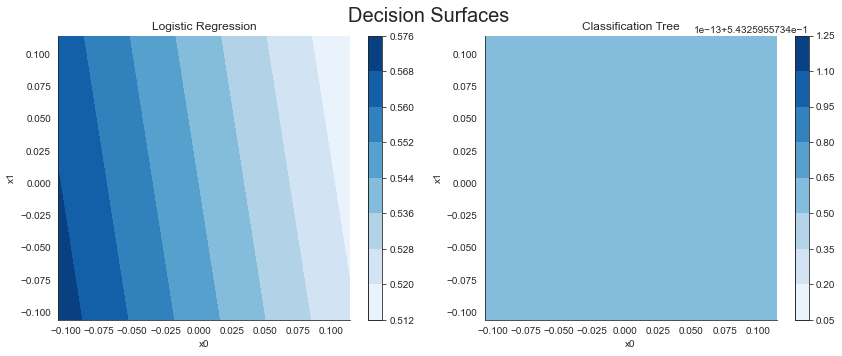

In [122]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
rex0 = log_reg_sk.predict_proba(X_data)[:, 1].reshape(x0.shape)
surface1 = axes[0].contourf(x0, x1, rex0, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
rex1 = clf_tree_t2.predict_proba(X_data)[:, 1].reshape(x0.shape)
surface2 = axes[1].contourf(x0, x1, rex1, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

Now with all the features

In [123]:
X = pd.get_dummies(data.drop('Target', axis=1))
y = data["Target"]




In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
regression_tree = DecisionTreeRegressor(criterion='mse',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None)

In [126]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [ ]:
out_file = results_path / 'reg_tree.dot'
dot_data = export_graphviz(regression_tree,
                           out_file=out_file.as_posix(),
                           feature_names=X_train.columns,
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [128]:
y_pred = regression_tree.predict(X_test)

In [129]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.043225555610332686

In [137]:
r, p = spearmanr(y_pred, y_test)
print(f'{r*100:.2f} (p-value={p:.2%})')

-0.48 (p-value=94.60%)


In [138]:


y_binary = (y>0).astype(int)
y_binary.value_counts()



1    542
0    454
Name: Target, dtype: int64

In [139]:


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)



In [140]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

In [141]:


clf.fit(X=X_train, y=y_train)



DecisionTreeClassifier(max_depth=5, random_state=42)

In [142]:


y_score = clf.predict_proba(X=X_test)[:, 1]



In [143]:
roc_auc_score(y_score=y_score, y_true=y_test)

0.5605622157916496

In [144]:
from sklearn.tree._tree import Tree
help(Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

In [40]:
n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits, 
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [41]:


max_depths = range(1, 16)



In [42]:
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
              'min_samples_leaf': [5, 25, 50, 100],
              'max_features': ['sqrt', 'auto']}

In [43]:
clf = DecisionTreeClassifier(random_state=42)

In [44]:


gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=cv,
                          refit=True,
                          return_train_score=True)

